<a href="https://colab.research.google.com/github/Monaa48/Hands-On-Machine-Learning-with-Scikit-Learn-Keras-and-TensorFlow/blob/main/notebooks/ch17_autoencoders_gans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chapter 17 — Representation Learning and Generative Learning Using Autoencoders and GANs

## 1) Summary
In this chapter, I work on **representation learning** (learning useful compressed features) and **generative learning**
(learning to generate new samples from a learned distribution).

What I implement and document:
- **Autoencoders**
  - a simple dense autoencoder
  - a convolutional autoencoder (better for images)
  - denoising autoencoder (robust representations)
- **Variational Autoencoder (VAE)**
  - probabilistic latent space (mean + log-variance)
  - reparameterization trick
  - reconstruction loss + KL divergence
- **GANs (Generative Adversarial Networks)**
  - generator vs discriminator game
  - custom training loop (because GAN training is not a standard supervised problem)
  - generating sample images during training

I use MNIST/Fashion-MNIST so the notebook stays runnable in Colab quickly.
My workflow mirrors Chapter 2:
dataset → baseline model → improved architecture → evaluation → interpretation (visual samples).

In [ ]:
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

np.random.seed(42)
tf.random.set_seed(42)

print("TensorFlow:", tf.__version__)
print("GPU available:", bool(tf.config.list_physical_devices("GPU")))

TensorFlow: 2.19.0
GPU available: True


## 2) Concept Notes (Autoencoders + GANs)

### 2.1 Representation learning
Instead of hand-engineering features, neural nets can learn latent representations automatically.
Autoencoders learn a compressed latent code that preserves useful information for reconstruction.

### 2.2 Autoencoder structure
- Encoder: x → z
- Decoder: z → x_hat
Training objective: minimize reconstruction error (e.g., MSE or BCE).

### 2.3 Denoising autoencoder
Input is a corrupted version of x (noise), but target is the clean x.
This encourages robust features rather than memorizing pixels.

### 2.4 Variational Autoencoder (VAE)
VAE learns a **distribution** in latent space:
- encoder outputs μ(x), logσ²(x)
- sample z = μ + σ ⊙ ε  (reparameterization trick)
Loss = reconstruction loss + KL divergence to a prior N(0, I).
Result: smooth latent space that supports sampling/generation.

### 2.5 GAN objective (game)
- Discriminator D tries to classify real vs fake.
- Generator G tries to fool D.
They are trained alternately.
GANs can produce sharp samples, but training can be unstable (mode collapse, oscillations).

### 2.6 Why custom training loops?
GAN training needs alternating updates and different losses for D and G.
So we typically implement GAN training with `tf.GradientTape`.

In [ ]:
def show_images(images, n=16, title=None):
    plt.figure(figsize=(6, 6))
    for i in range(n):
        plt.subplot(int(np.sqrt(n)), int(np.sqrt(n)), i+1)
        img = images[i]
        if img.shape[-1] == 1:
            img = img.squeeze(-1)
        plt.imshow(img, cmap="binary")
        plt.axis("off")
    if title:
        plt.suptitle(title)
    plt.tight_layout()
    plt.show()

# Part A — Autoencoders (MNIST)

## 3) Load dataset
I use MNIST to visualize reconstructions and generated samples easily.
Steps:
- scale to [0,1]
- flatten for dense autoencoder
- keep image shape for conv autoencoder

In [ ]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.mnist.load_data()

X_train_full = X_train_full.astype(np.float32) / 255.0
X_test = X_test.astype(np.float32) / 255.0

# train/valid split
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]

# Dense AE uses flat vectors
X_train_flat = X_train.reshape(-1, 28*28)
X_valid_flat = X_valid.reshape(-1, 28*28)
X_test_flat  = X_test.reshape(-1, 28*28)

X_train.shape, X_train_flat.shape

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


((55000, 28, 28), (55000, 784))

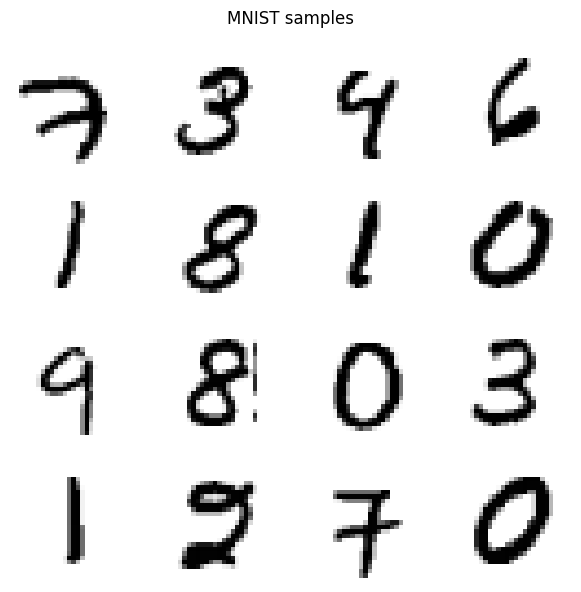

In [ ]:
show_images(X_train[:16][..., np.newaxis], n=16, title="MNIST samples")

## 4) Dense autoencoder (baseline)
Architecture:
- Encoder: Dense → Dense(latent_dim)
- Decoder: Dense → Dense(784, sigmoid)

Loss:
- Binary crossentropy works well for normalized pixels in [0,1].

In [ ]:
latent_dim = 32

dense_encoder = keras.models.Sequential([
    keras.layers.Input(shape=(28*28,)),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dense(latent_dim, activation="relu")
])

dense_decoder = keras.models.Sequential([
    keras.layers.Input(shape=(latent_dim,)),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dense(28*28, activation="sigmoid")
])

# Corrected way to build the autoencoder model
inputs = keras.layers.Input(shape=(28*28,))
encoded = dense_encoder(inputs)
decoded = dense_decoder(encoded)
dense_ae = keras.Model(inputs, decoded)

dense_ae.compile(optimizer="adam", loss="binary_crossentropy")

dense_ae.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_2 (Sequential)       │ (None, 32)             │       104,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_3 (Sequential)       │ (None, 784)            │       105,360 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 209,968 (820.19 KB)

 Trainable params: 209,968 (820.19 KB)

 Non-trainable params: 0 (0.00 B)

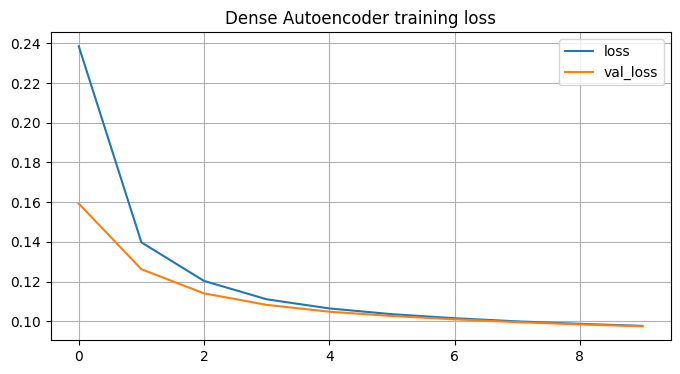

In [ ]:
hist_dense = dense_ae.fit(
    X_train_flat, X_train_flat,
    epochs=10,
    batch_size=256,
    validation_data=(X_valid_flat, X_valid_flat),
    verbose=0
)

pd.DataFrame(hist_dense.history).plot(figsize=(8, 4), grid=True, title="Dense Autoencoder training loss")
plt.show()

## 5) Reconstruction check
I compare original images vs reconstructed images from the dense autoencoder.

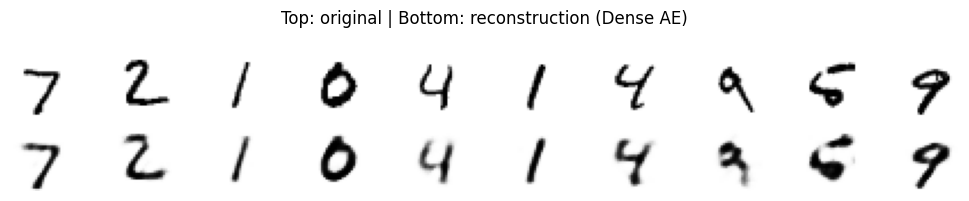

In [ ]:
n = 10
X_sample = X_test_flat[:n]
X_recon = dense_ae.predict(X_sample, verbose=0).reshape(-1, 28, 28)

plt.figure(figsize=(10, 2))
for i in range(n):
    plt.subplot(2, n, i+1)
    plt.imshow(X_sample[i].reshape(28, 28), cmap="binary")
    plt.axis("off")
    plt.subplot(2, n, n+i+1)
    plt.imshow(X_recon[i], cmap="binary")
    plt.axis("off")
plt.suptitle("Top: original | Bottom: reconstruction (Dense AE)")
plt.tight_layout()
plt.show()

## 6) Convolutional autoencoder
Conv autoencoders are usually better for images because they preserve spatial structure.
Architecture:
- Encoder: Conv → Pool → Conv → Pool
- Decoder: ConvTranspose / UpSampling to reconstruct

In [ ]:
# Prepare images with channel dimension
X_train_img = X_train[..., np.newaxis]
X_valid_img = X_valid[..., np.newaxis]
X_test_img  = X_test[..., np.newaxis]

conv_encoder = keras.models.Sequential([
    keras.layers.Input(shape=(28, 28, 1)),
    keras.layers.Conv2D(32, 3, padding="same", activation="relu"),
    keras.layers.MaxPooling2D(2, padding="same"),
    keras.layers.Conv2D(64, 3, padding="same", activation="relu"),
    keras.layers.MaxPooling2D(2, padding="same"),
])

conv_decoder = keras.models.Sequential([
    keras.layers.Input(shape=(7, 7, 64)),
    keras.layers.Conv2DTranspose(64, 3, strides=2, padding="same", activation="relu"),
    keras.layers.Conv2DTranspose(32, 3, strides=2, padding="same", activation="relu"),
    keras.layers.Conv2D(1, 3, padding="same", activation="sigmoid"),
])

# Corrected way to build the autoencoder model
conv_ae_input = keras.layers.Input(shape=(28, 28, 1))
encoded_output = conv_encoder(conv_ae_input)
decoded_output = conv_decoder(encoded_output)
conv_ae = keras.Model(conv_ae_input, decoded_output)

conv_ae.compile(optimizer="adam", loss="binary_crossentropy")

conv_ae.summary()

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)      │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_6 (Sequential)       │ (None, 7, 7, 64)       │        18,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_7 (Sequential)       │ (None, 28, 28, 1)      │        55,681 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 74,497 (291.00 KB)

 Trainable params: 74,497 (291.00 KB)

 Non-trainable params: 0 (0.00 B)

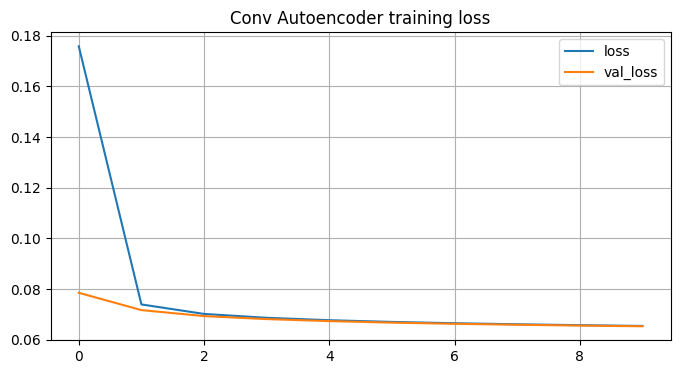

In [ ]:
hist_conv = conv_ae.fit(
    X_train_img, X_train_img,
    epochs=10,
    batch_size=256,
    validation_data=(X_valid_img, X_valid_img),
    verbose=0
)

pd.DataFrame(hist_conv.history).plot(figsize=(8, 4), grid=True, title="Conv Autoencoder training loss")
plt.show()

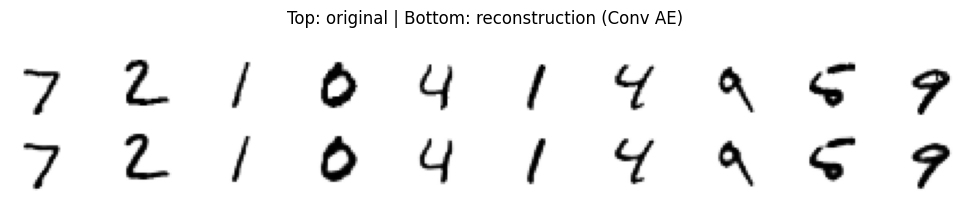

In [ ]:
n = 10
X_sample = X_test_img[:n]
X_recon = conv_ae.predict(X_sample, verbose=0)

plt.figure(figsize=(10, 2))
for i in range(n):
    plt.subplot(2, n, i+1)
    plt.imshow(X_sample[i].squeeze(-1), cmap="binary")
    plt.axis("off")
    plt.subplot(2, n, n+i+1)
    plt.imshow(X_recon[i].squeeze(-1), cmap="binary")
    plt.axis("off")
plt.suptitle("Top: original | Bottom: reconstruction (Conv AE)")
plt.tight_layout()
plt.show()

## 7) Denoising autoencoder
I corrupt inputs with noise, but the target remains the clean image.
This forces the autoencoder to learn more robust representations.

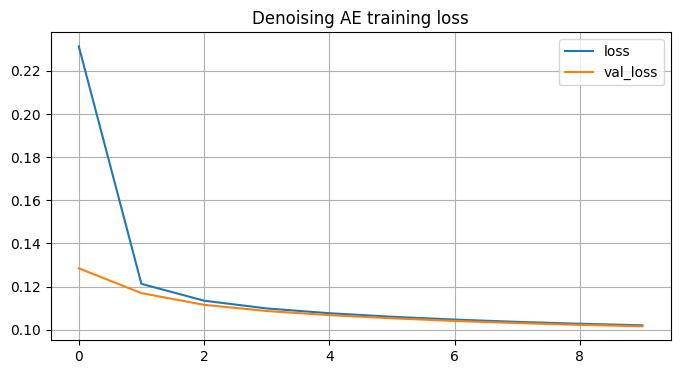

In [ ]:
noise_factor = 0.5
X_train_noisy = np.clip(X_train_img + noise_factor * np.random.randn(*X_train_img.shape), 0., 1.).astype(np.float32)
X_valid_noisy = np.clip(X_valid_img + noise_factor * np.random.randn(*X_valid_img.shape), 0., 1.).astype(np.float32)
X_test_noisy  = np.clip(X_test_img  + noise_factor * np.random.randn(*X_test_img.shape),  0., 1.).astype(np.float32)

denoise_ae = keras.models.clone_model(conv_ae)
denoise_ae.compile(optimizer="adam", loss="binary_crossentropy")

hist_denoise = denoise_ae.fit(
    X_train_noisy, X_train_img,
    epochs=10,
    batch_size=256,
    validation_data=(X_valid_noisy, X_valid_img),
    verbose=0
)

pd.DataFrame(hist_denoise.history).plot(figsize=(8, 4), grid=True, title="Denoising AE training loss")
plt.show()

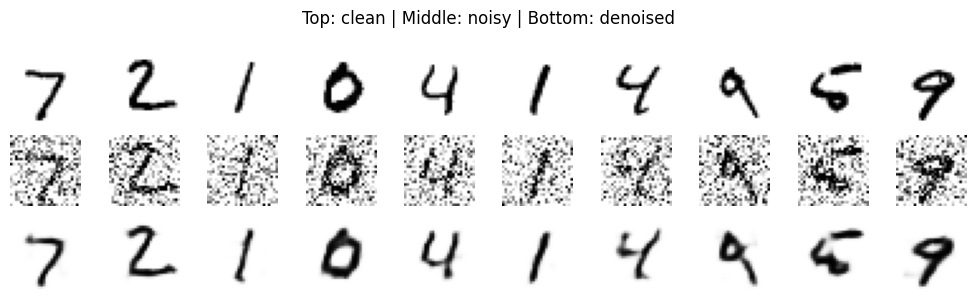

In [ ]:
n = 10
X_sample = X_test_noisy[:n]
X_denoised = denoise_ae.predict(X_sample, verbose=0)

plt.figure(figsize=(10, 3))
for i in range(n):
    plt.subplot(3, n, i+1)
    plt.imshow(X_test_img[i].squeeze(-1), cmap="binary")
    plt.axis("off")
    plt.subplot(3, n, n+i+1)
    plt.imshow(X_sample[i].squeeze(-1), cmap="binary")
    plt.axis("off")
    plt.subplot(3, n, 2*n+i+1)
    plt.imshow(X_denoised[i].squeeze(-1), cmap="binary")
    plt.axis("off")
plt.suptitle("Top: clean | Middle: noisy | Bottom: denoised")
plt.tight_layout()
plt.show()

# Part B — Variational Autoencoder (VAE)

## 8) Why VAE?
Regular autoencoders are not guaranteed to have a smooth latent space suitable for sampling.
A VAE explicitly regularizes the latent distribution to be close to N(0, I),
which makes sampling meaningful.

Implementation:
- Encoder outputs (z_mean, z_log_var)
- Sampling layer uses reparameterization trick
- Decoder reconstructs image
Loss:
- reconstruction loss (binary crossentropy)
- + KL divergence

In [ ]:
vae_latent_dim = 16

# Encoder
encoder_inputs = keras.layers.Input(shape=(28, 28, 1))
x = keras.layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = keras.layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(128, activation="relu")(x)
z_mean = keras.layers.Dense(vae_latent_dim, name="z_mean")(x)
z_log_var = keras.layers.Dense(vae_latent_dim, name="z_log_var")(x)

# Sampling
class Sampling(keras.layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        eps = tf.random.normal(shape=tf.shape(z_mean))
        return z_mean + tf.exp(0.5 * z_log_var) * eps

z = Sampling()([z_mean, z_log_var])
vae_encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="vae_encoder")
vae_encoder.summary()

Model: "vae_encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10      │ (None, 28, 28, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 14, 14,    │        320 │ input_layer_10[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 7, 7, 64)  │     18,496 │ conv2d_6[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 3136)      │          0 │ conv2d_7[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 128)       │    401,536 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 16)        │      2,064 │ dense_8[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 16)        │      2,064 │ dense_8[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling (Sampling) │ (None, 16)        │          0 │ z_mean[0][0],     │
│                     │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 424,480 (1.62 MB)

 Trainable params: 424,480 (1.62 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Decoder
latent_inputs = keras.layers.Input(shape=(vae_latent_dim,))
x = keras.layers.Dense(7*7*64, activation="relu")(latent_inputs)
x = keras.layers.Reshape((7, 7, 64))(x)
x = keras.layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = keras.layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = keras.layers.Conv2D(1, 3, activation="sigmoid", padding="same")(x)
vae_decoder = keras.Model(latent_inputs, decoder_outputs, name="vae_decoder")
vae_decoder.summary()

Model: "vae_decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_11 (InputLayer)     │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 3136)           │        53,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_4              │ (None, 14, 14, 64)     │        36,928 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_5              │ (None, 28, 28, 32)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 28, 28, 1)      │           289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 108,993 (425.75 KB)

 Trainable params: 108,993 (425.75 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="loss")
        self.recon_loss_tracker = keras.metrics.Mean(name="recon_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [self.total_loss_tracker, self.recon_loss_tracker, self.kl_loss_tracker]

    def _compute_losses(self, x, training):
        z_mean, z_log_var, z = self.encoder(x, training=training)
        x_recon = self.decoder(z, training=training)

        recon_loss = tf.reduce_mean(
            tf.reduce_sum(keras.losses.binary_crossentropy(x, x_recon), axis=(1, 2))
        )
        kl_loss = -0.5 * tf.reduce_mean(
            tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1)
        )
        total_loss = recon_loss + kl_loss
        return total_loss, recon_loss, kl_loss

    def train_step(self, data):
        x = data[0] if isinstance(data, (tuple, list)) else data
        with tf.GradientTape() as tape:
            total_loss, recon_loss, kl_loss = self._compute_losses(x, training=True)
        grads = tape.gradient(total_loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))

        self.total_loss_tracker.update_state(total_loss)
        self.recon_loss_tracker.update_state(recon_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "recon_loss": self.recon_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

    def test_step(self, data):
        x = data[0] if isinstance(data, (tuple, list)) else data
        total_loss, recon_loss, kl_loss = self._compute_losses(x, training=False)

        self.total_loss_tracker.update_state(total_loss)
        self.recon_loss_tracker.update_state(recon_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "recon_loss": self.recon_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }


In [ ]:
vae = VAE(vae_encoder, vae_decoder)
vae.compile(optimizer=keras.optimizers.Adam(1e-3))

val_ds = tf.data.Dataset.from_tensor_slices(X_valid_img).batch(256)

hist_vae = vae.fit(
    X_train_img,
    epochs=10,
    batch_size=256,
    validation_data=val_ds,
    verbose=0
)


## 9) Sample from the VAE latent space
After training, I can sample z ~ N(0, I) and decode it to an image.

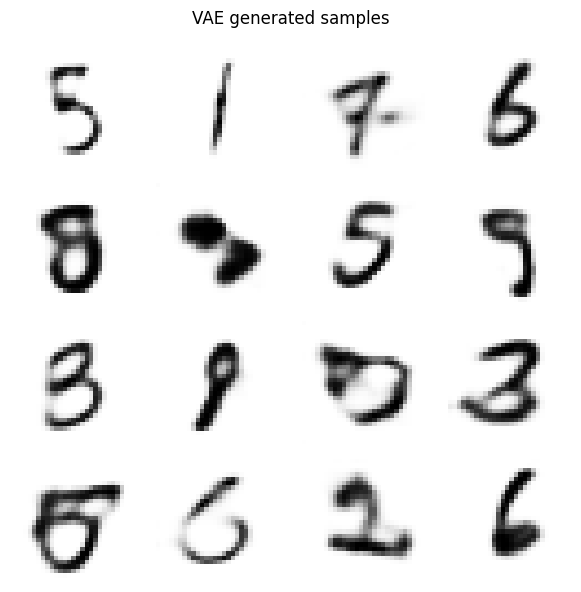

In [ ]:
n = 16
z_samples = tf.random.normal(shape=(n, vae_latent_dim))
generated = vae_decoder.predict(z_samples, verbose=0)

show_images(generated, n=16, title="VAE generated samples")

# Part C — GAN (DCGAN-style on MNIST)

## 10) Why DCGAN?
A DCGAN uses convolutional generator and discriminator.
It is a standard first GAN setup for MNIST-like datasets.

Training loop:
- Train discriminator on real images (label=1) and fake images (label=0)
- Train generator to produce images that discriminator labels as real

Notes:
GAN training can be unstable. I keep:
- small learning rate
- label smoothing (optional)
- and log sample images during training.

In [ ]:
# Prepare MNIST as float32 in [-1, 1] for GAN (tanh output)
X_train_gan = (X_train_img * 2.0 - 1.0).astype(np.float32)

buffer_size = len(X_train_gan)
batch_size = 256

gan_ds = tf.data.Dataset.from_tensor_slices(X_train_gan).shuffle(buffer_size, seed=42).batch(batch_size, drop_remainder=True).prefetch(tf.data.AUTOTUNE)

In [ ]:
latent_dim_gan = 100

def build_generator():
    model = keras.models.Sequential([
        keras.layers.Input(shape=(latent_dim_gan,)),
        keras.layers.Dense(7*7*128, use_bias=False),
        keras.layers.BatchNormalization(),
        keras.layers.LeakyReLU(),
        keras.layers.Reshape((7, 7, 128)),

        keras.layers.Conv2DTranspose(64, 5, strides=2, padding="same", use_bias=False),
        keras.layers.BatchNormalization(),
        keras.layers.LeakyReLU(),

        keras.layers.Conv2DTranspose(32, 5, strides=2, padding="same", use_bias=False),
        keras.layers.BatchNormalization(),
        keras.layers.LeakyReLU(),

        keras.layers.Conv2D(1, 5, padding="same", activation="tanh")
    ])
    return model

def build_discriminator():
    model = keras.models.Sequential([
        keras.layers.Input(shape=(28, 28, 1)),
        keras.layers.Conv2D(64, 5, strides=2, padding="same"),
        keras.layers.LeakyReLU(0.2),
        keras.layers.Dropout(0.3),

        keras.layers.Conv2D(128, 5, strides=2, padding="same"),
        keras.layers.LeakyReLU(0.2),
        keras.layers.Dropout(0.3),

        keras.layers.Flatten(),
        keras.layers.Dense(1)  # logits
    ])
    return model

generator = build_generator()
discriminator = build_discriminator()

generator.summary()
discriminator.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_22 (Dense)                │ (None, 6272)           │       627,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 6272)           │        25,088 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_7 (Reshape)             │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_18             │ (None, 14, 14, 64)     │       204,800 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_19             │ (None, 28, 28, 32)     │        51,200 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 28, 28, 1)      │           801 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 909,473 (3.47 MB)

 Trainable params: 896,737 (3.42 MB)

 Non-trainable params: 12,736 (49.75 KB)

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_28 (Conv2D)              │ (None, 14, 14, 64)     │         1,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 7, 7, 128)      │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 1)              │         6,273 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 212,865 (831.50 KB)

 Trainable params: 212,865 (831.50 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Losses and optimizers
bce = keras.losses.BinaryCrossentropy(from_logits=True)

gen_opt = keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5)
disc_opt = keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5)

def discriminator_loss(real_logits, fake_logits):
    real_labels = tf.ones_like(real_logits) * 0.9  # label smoothing
    fake_labels = tf.zeros_like(fake_logits)
    real_loss = bce(real_labels, real_logits)
    fake_loss = bce(fake_labels, fake_logits)
    return real_loss + fake_loss

def generator_loss(fake_logits):
    return bce(tf.ones_like(fake_logits), fake_logits)

In [ ]:
@tf.function
def train_gan_step(real_images):
    noise = tf.random.normal([batch_size, latent_dim_gan])

    with tf.GradientTape() as disc_tape, tf.GradientTape() as gen_tape:
        fake_images = generator(noise, training=True)

        real_logits = discriminator(real_images, training=True)
        fake_logits = discriminator(fake_images, training=True)

        d_loss = discriminator_loss(real_logits, fake_logits)
        g_loss = generator_loss(fake_logits)

    d_grads = disc_tape.gradient(d_loss, discriminator.trainable_variables)
    g_grads = gen_tape.gradient(g_loss, generator.trainable_variables)

    disc_opt.apply_gradients(zip(d_grads, discriminator.trainable_variables))
    gen_opt.apply_gradients(zip(g_grads, generator.trainable_variables))
    return d_loss, g_loss

## 11) Train the GAN (short run)
I keep the epoch count low to keep Colab runtime reasonable.
If you want higher-quality samples, increase epochs.

Epoch 01 | d_loss=1.3471 | g_loss=0.7878 | time=15.8s


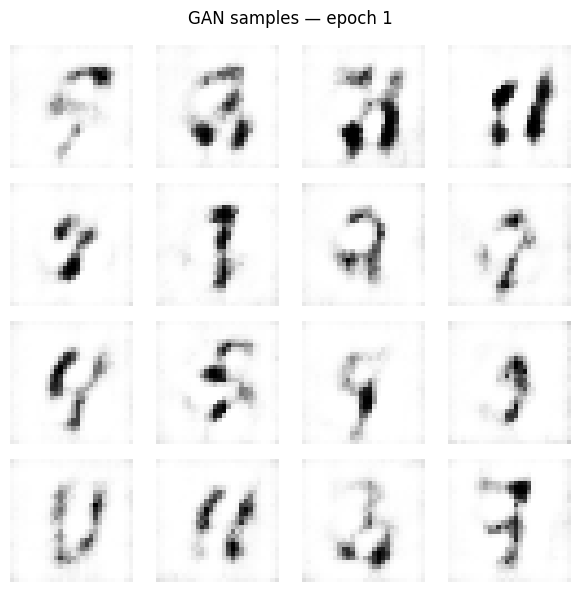

Epoch 02 | d_loss=1.3627 | g_loss=0.8165 | time=10.8s
Epoch 03 | d_loss=1.3228 | g_loss=0.8540 | time=10.8s
Epoch 04 | d_loss=1.2867 | g_loss=0.8973 | time=10.9s
Epoch 05 | d_loss=1.2730 | g_loss=0.9141 | time=10.9s


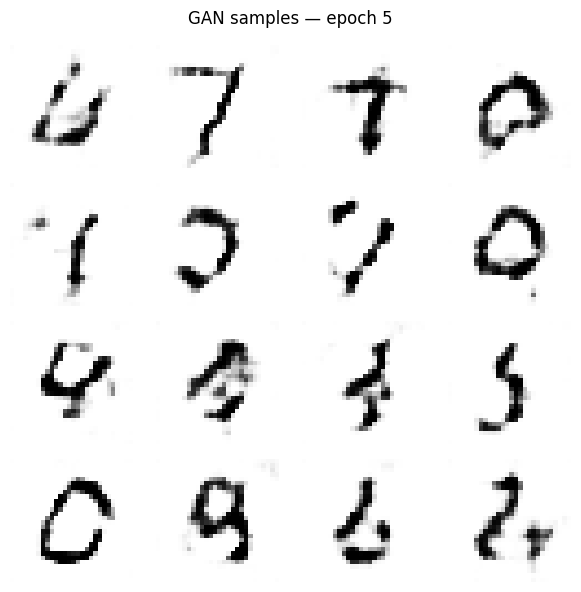

Epoch 06 | d_loss=1.3096 | g_loss=0.8879 | time=10.8s
Epoch 07 | d_loss=1.3104 | g_loss=0.8894 | time=10.8s
Epoch 08 | d_loss=1.3122 | g_loss=0.8865 | time=10.8s
Epoch 09 | d_loss=1.3099 | g_loss=0.8898 | time=10.8s
Epoch 10 | d_loss=1.3100 | g_loss=0.8928 | time=10.8s


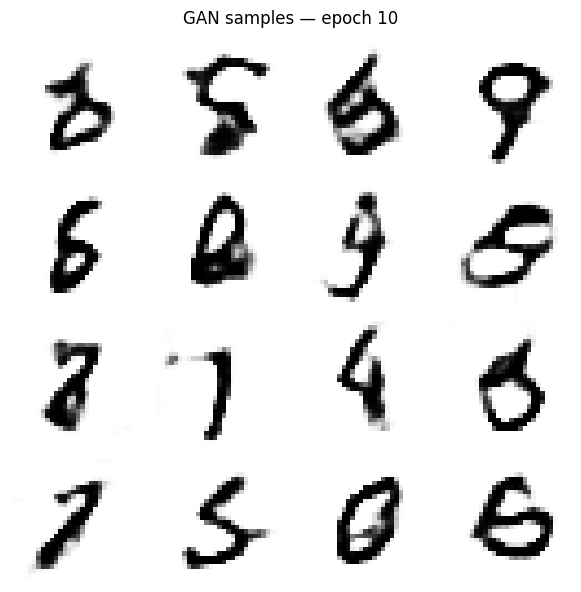

In [ ]:
def generate_and_plot(generator, epoch, n=16):
    noise = tf.random.normal([n, latent_dim_gan])
    fake = generator(noise, training=False)
    fake = (fake + 1.0) / 2.0  # back to [0,1]
    show_images(fake.numpy(), n=n, title=f"GAN samples — epoch {epoch}")

epochs = 10
history_gan = {"d_loss": [], "g_loss": []}

for epoch in range(1, epochs + 1):
    start = time.time()
    d_losses = []
    g_losses = []
    for real_batch in gan_ds:
        d_loss, g_loss = train_gan_step(real_batch)
        d_losses.append(float(d_loss))
        g_losses.append(float(g_loss))

    d_mean = float(np.mean(d_losses))
    g_mean = float(np.mean(g_losses))
    history_gan["d_loss"].append(d_mean)
    history_gan["g_loss"].append(g_mean)

    print(f"Epoch {epoch:02d} | d_loss={d_mean:.4f} | g_loss={g_mean:.4f} | time={time.time()-start:.1f}s")

    if epoch in [1, 5, 10]:
        generate_and_plot(generator, epoch, n=16)

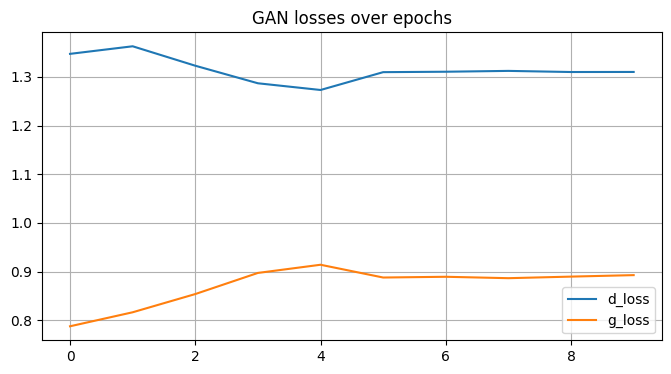

In [ ]:
pd.DataFrame(history_gan).plot(figsize=(8, 4), grid=True, title="GAN losses over epochs")
plt.show()

## 12) Takeaways
- Autoencoders learn representations by reconstructing inputs.
- Conv autoencoders usually reconstruct images better than dense autoencoders because they preserve spatial structure.
- Denoising autoencoders learn more robust features by learning to remove noise.
- VAEs learn a smooth probabilistic latent space, enabling meaningful sampling.
- GANs train a generator and discriminator in an adversarial game; they can generate sharp samples but can be unstable.
- For generative models, visual inspection of samples is an important part of evaluation (in addition to loss curves).

## 13) References
- Aurélien Géron, *Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow*, Chapter 17.
- Keras/TensorFlow docs: autoencoders, `tf.GradientTape`, `Conv2DTranspose`, `BinaryCrossentropy`, GAN training patterns.